In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def read_obj_points(filename):
    points = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('v '):  # ligne de sommet
                parts = line.strip().split()
                x, y, z = map(float, parts[1:4])
                points.append([x, y, z])
    return np.array(points)

In [5]:
# load 3d object 
obj_points = read_obj_points('./assets/cat1_un4.obj')

### Intrinsic Parameters of Camera :
$$
K = 
\begin{bmatrix}
\alpha & -\alpha \cot \theta & c_x \\
0 & \dfrac{\beta}{\sin \theta} & c_y \\
0 & 0 & 1
\end{bmatrix}
=
\begin{bmatrix}
f_x & s & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}.
$$

In [6]:
def generate_K(fx,fy,cx,cy,s):
    """
    fx,fy : focal
    s: skew (cisaillement)
    cx, cy : centre optique
    """
    K = np.array([
        [fx, s,   cx],
        [0,   fy, cy],
        [0,    0,   1]
    ])
    return K

In [7]:
def project_points_fixed_camera(points_3d, K):
    points_2d = []
    for X, Y, Z in points_3d:
        p = np.array([X, Y, Z])
        proj = K @ (p / Z)
        points_2d.append(proj[:2])
    return np.array(points_2d)

In [8]:
def generate_binary_image(points_2d, width=300, height=300):
    img = np.zeros((height, width))
    for x, y in points_2d:
        xi, yi = int(x), int(y)
        if 0 <= xi < width and 0 <= yi < height:
            img[yi, xi] = 1
    return img

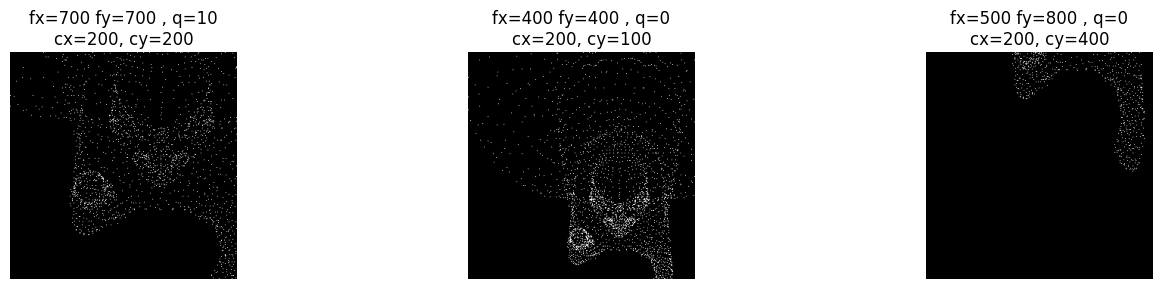

In [9]:
params_list = [
    (700, 700, 200, 200, 10),
    (400, 400, 200, 100, 0),
    (500, 800, 200, 400, 0),
]

# --- Visualisation des effets ---
fig, axes = plt.subplots(1, len(params_list), figsize=(15, 3))

for i, (fx,fy,cx,cy,s) in enumerate(params_list):
    K = generate_K(fx,fy,cx,cy,s)
    pts_2d = project_points_fixed_camera(obj_points, K)
    img = generate_binary_image(pts_2d)
    axes[i].imshow(img, cmap='gray', origin='lower')
    axes[i].set_title(f"fx={fx} fy={fy} , q={s}\ncx={cx}, cy={cy}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Extrinsic Parameters (Camera Rotation and Translation)

The **extrinsic parameters** describe the position and orientation of the camera with respect to the world coordinate system.  
They define how a 3D point in the world, $P^W = [X_W, Y_W, Z_W]^T$, is transformed into the camera coordinate system $P^C = [X_C, Y_C, Z_C]^T$.

This transformation is expressed as:


$ P^C = R_W^C \cdot P^W + t_W^C $


where:
- $ R_W^C $ is the **rotation matrix** (3×3) describing the orientation of the camera relative to the world.
- $ t_W^C $  is the **translation vector** (3×1) describing the position of the camera in the world coordinate system.

Then, to project the 3D point onto the image plane using the intrinsic parameters matrix $K$, we write:

$
Zp = K \, P^C = K \left( R_W^C \cdot P^W + t_W^C \right)
$

or equivalently,

$
Zp = K(RP + t)
$

Combining both intrinsic and extrinsic parameters into one matrix gives the **camera projection matrix**:

$
Zp = K [R \, t] P
$

$
M = K [R \, t]
$

where $M$ is the **$3 \times 4$ projection matrix** that maps 3D world points to 2D image coordinates.

---

#### Rotation Matrices

The rotation matrix $R$ can be decomposed into three rotations around the **X**, **Y**, and **Z** axes:

- **Rotation around X-axis (pitch):**

$
R_x(\theta_x) =
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos\theta_x & -\sin\theta_x \\
0 & \sin\theta_x & \cos\theta_x
\end{bmatrix}
$

- **Rotation around Y-axis (yaw):**

$
R_y(\theta_y) =
\begin{bmatrix}
\cos\theta_y & 0 & \sin\theta_y \\
0 & 1 & 0 \\
-\sin\theta_y & 0 & \cos\theta_y
\end{bmatrix}
$

- **Rotation around Z-axis (roll):**

$
R_z(\theta_z) =
\begin{bmatrix}
\cos\theta_z & -\sin\theta_z & 0 \\
\sin\theta_z & \cos\theta_z & 0 \\
0 & 0 & 1
\end{bmatrix}
$

The complete rotation matrix can be obtained by combining these three individual rotations, depending on the convention used (e.g., $R = R_z R_y R_x$).

---
$
\boxed{
Zp = K [R \, t] P, \quad \text{where} \quad M = K[R \, t]
}
$


In [10]:
def generate_rotation_matrix(alpha, beta, gama):
    rot_x_matrix = np.array([[1, 0, 0], [0, np.cos(alpha), -np.sin(alpha)], [0, np.sin(alpha), np.cos(alpha)]])
    rot_y_matrix = np.array([[np.cos(beta), 0, np.sin(beta)], [0, 1, 0], [-np.sin(beta), 0, np.cos(beta)]])
    rot_z_matrix = np.array([[np.cos(gama), -np.sin(gama), 0], [np.sin(gama), np.cos(gama), 0], [0, 0, 1]])
    return rot_x_matrix, rot_y_matrix, rot_z_matrix


In [11]:
# Compose rotation (apply Z, then Y, then X)
rot_x_matrix, rot_y_matrix, rot_z_matrix = generate_rotation_matrix(alpha=np.pi/2, beta=np.pi/3, gama=0)

# Compose rotation (apply Z, then Y, then X)
R = rot_z_matrix @ rot_y_matrix @ rot_x_matrix

# Example translation (move object away from camera along Z)
t = np.array([0.0, 0.0, 300.0])  # change as needed

# Choose an intrinsic matrix (reuse generate_K)
K = generate_K(fx=700, fy=700, cx=200, cy=400, s=10)

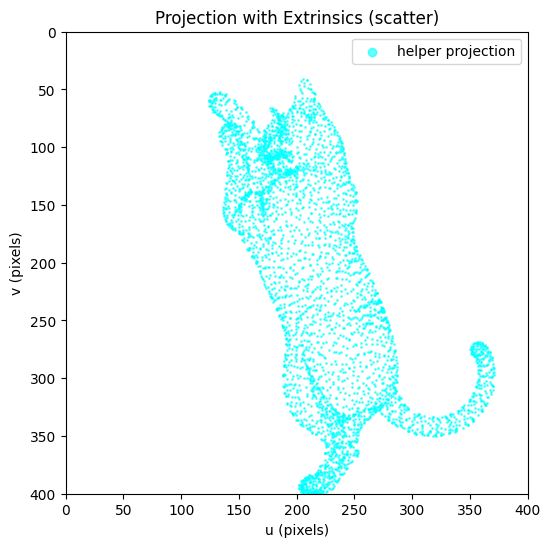

In [12]:
# Build full 3x4 projection matrix M = K [R | t]
Rt = np.hstack((R, t.reshape(3, 1)))
M = K @ Rt

# Project via homogeneous coordinates using M
homog = M @ np.vstack((obj_points.T, np.ones(obj_points.shape[0])))  # 3 x N
u = homog[0, :] / homog[2, :]
v = homog[1, :] / homog[2:]

# Also compute by transforming to camera coordinates then using existing helper
cam_pts = (R @ obj_points.T).T + t  # N x 3
pts2d_helper = project_points_fixed_camera(cam_pts, K)  # N x 2 (should match u,v)

# Plot results (M-based vs helper)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(pts2d_helper[:, 0], pts2d_helper[:, 1], s=1, c='cyan', alpha=0.6, label='helper projection')
ax.set_xlim(0, 400)
ax.set_ylim(0, 400)
ax.set_title('Projection with Extrinsics (scatter)')
ax.set_xlabel('u (pixels)')
ax.set_ylabel('v (pixels)')
ax.legend(markerscale=6)
ax.set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()  # if you prefer origin at top-left, remove this line to keep origin bottom-left
plt.show()

### Estimation of the Pose

The goal is to estimate the **pose** of the camera, represented by the projection matrix \( P \),  
given a set of **2D–3D correspondences** between world points and their image projections.

### Step 1: Formulate the Problem

Given a 3D point $ M = [X, Y, Z, 1]^T $ in homogeneous coordinates  
and its corresponding 2D image point $ m = [u, v, 1]^T $,  
the projection relation is given by:

$
m = P M
$

where $ P $ is the $ 3 \times 4 $ **camera projection matrix** that combines both intrinsic and extrinsic parameters.

To eliminate the scale ambiguity, this can be rewritten as a **homogeneous system**:

$
P M = \mathbf{0}
$

This formulation allows us to solve for $ P $ (up to a scale factor) using multiple 2D–3D correspondences.

---

### Step 2: Set Up the System of Equations

For a single correspondence between a 3D point $ M_i = [X_i, Y_i, Z_i, 1]^T $  
and its image projection $ m_i = [u_i, v_i, 1]^T $,  
we can write the following two equations:

$$
P_1^T M_i - u_i (P_3^T M_i) = 0
$$
$$
P_2^T M_i - v_i (P_3^T M_i) = 0
$$

where:
- $ P_1^T, P_2^T, P_3^T $ are the rows of the projection matrix $ P $,
- $ (u_i, v_i) $ are the image coordinates of the projection of $ M_i $.

Stacking all equations from $ n $ correspondences gives a **linear system**:

$
A \, p = \mathbf{0}
$

where:
- $ A $ is a $ 2n \times 12 $ matrix built from known image and world coordinates,
- $ p $ is a $ 12 \times 1 $ vector containing the unknown elements of $ P $.

---

### Step 3: Solve Using Singular Value Decomposition (SVD)

The homogeneous linear system $ A p = \mathbf{0} $ can be solved using **SVD**.

We decompose $ A $ as:

$
A = U D V^T
$

The solution for $ p $ that minimizes $ \| A p \| $ under the constraint $ \| p \| = 1 $  
is the **column of $ V $** corresponding to the **smallest singular value** in $ D $:

$
p = V_{\text{min}}
$

Reshaping $ p $ into a $ 3 \times 4 $ matrix gives the **estimated projection matrix** $ P $:

$
P =
\begin{bmatrix}
p_1 & p_2 & p_3 & p_4 \\
p_5 & p_6 & p_7 & p_8 \\
p_9 & p_{10} & p_{11} & p_{12}
\end{bmatrix}
$

---

### Step 4: Decomposition of the Projection Matrix

We can express $ P $ as:

$
P = [a_1 \; a_2 \; a_3 \; b]
$

where:
- $ a_1, a_2, a_3 $ are the first three columns of $ P $, and  
- $ b $ is the last column.

We know that:

$
P = K [R \,|\, t]
$

with:
- $ K $ : intrinsic matrix,  
- $ R $ : rotation matrix,  
- $ t $ : translation vector.

---

### Step 5: Compute the Intrinsic Parameters

#### Scale factor
$
\rho = \pm \frac{1}{\|a_3\|}
$

#### Principal point
$
c_x = \rho^2 (a_1 \cdot a_3)
$
$
c_y = \rho^2 (a_2 \cdot a_3)
$

#### Skew angle
$
\cos \theta = - \frac{(a_1 \times a_3) \cdot (a_2 \times a_3)}{ \|a_1 \times a_3\| \, \|a_2 \times a_3\| }
$

#### Focal lengths
$
\alpha = \rho^2 \|a_1 \times a_3\| \sin \theta
$
$
\beta = \rho^2 \|a_2 \times a_3\| \sin \theta
$

#### Intrinsic matrix
$
K =
\begin{bmatrix}
\alpha & -\alpha \cot\theta & c_x \\
0 & \beta / \sin\theta & c_y \\
0 & 0 & 1
\end{bmatrix}
$

---

### Step 6: Compute the Extrinsic Parameters

$
r_1 = \frac{a_2 \times a_3}{\|a_2 \times a_3\|}
$
$
r_3 = \rho a_3
$
$
r_2 = r_3 \times r_1
$
$
t = \rho K^{-1} b
$

---

### Step 7: Rotation Matrix Normalization

To ensure orthonormality of $ R $:

$
R = U V^T \quad \text{where } U \Sigma V^T = \text{SVD}(R)
$


In [14]:
def project_points(points_3d, M):
    """Project 3D points using full projection matrix M."""
    n = points_3d.shape[0]
    homog = np.hstack((points_3d, np.ones((n, 1))))  # N x 4
    proj = (M @ homog.T).T  # N x 3
    proj_2d = proj[:, :2] / proj[:, 2, np.newaxis]
    return proj_2d


In [15]:
def estimate_projection_matrix(obj_points, img_points):
    n = obj_points.shape[0]
    A = []
    for i in range(n):
        X, Y, Z = obj_points[i]
        u, v = img_points[i]
        A.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u])
        A.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v])
    A = np.array(A)
    # Solve Ap=0 using SVD
    U, S, Vt = np.linalg.svd(A)
    p = Vt[-1, :]
    P_est = p.reshape(3, 4)
    return P_est

In [17]:
def decompose_projection_matrix(P):
    """Decompose projection matrix into K, R, t using RQ decomposition."""
    # Separate P = [M | b]
    M = P[:, :3]
    b = P[:, 3]

    # RQ decomposition for K and R
    from scipy.linalg import rq
    K, R = rq(M)

    # Ensure positive diagonal in K
    T = np.diag(np.sign(np.diag(K)))
    K = K @ T
    R = T @ R

    # Normalize K so that K[2,2] = 1
    K /= K[2, 2]

    # Compute translation
    t = np.linalg.inv(K) @ b

    return K, R, t


In [13]:
# Example parameters
K = generate_K(fx=800, fy=800, cx=320, cy=240, s=0)
rot_x, rot_y, rot_z = generate_rotation_matrix(np.radians(15), np.radians(10), np.radians(5))
R = rot_z @ rot_y @ rot_x  # Compose rotation matrices
t = np.array([0.2, -0.1, 3.0])  # translation in world units

# Full projection matrix
M = K @ np.hstack((R, t.reshape(3, 1)))

In [ ]:
projected_points = project_points(obj_points, M)

# sample 6 points is the minimum number of points required because each points gives us 2 equations and we have 11 unknowns
# so we need at least 6 points
sample_points = 6
sample_indices = np.random.choice(obj_points.shape[0], sample_points, replace=False)
sample_points_3d = obj_points[sample_indices]
sample_points_2d = projected_points[sample_indices]

# Estimate projection matrix
P_est = estimate_projection_matrix(sample_points_3d, sample_points_2d)

# Decompose estimated projection matrix
K_est, R_est, t_est = decompose_projection_matrix(P_est)

In [22]:
np.set_printoptions(precision=3, suppress=True)

print("=== True Intrinsics (K) ===")
print(K)
print("\n=== Estimated Intrinsics (K_est) ===")
print(K_est)

print("\n=== True Rotation (R) ===")
print(R)
print("\n=== Estimated Rotation (R_est) ===")
print(R_est)

print("\n=== True Translation (t) ===")
print(t)
print("\n=== Estimated Translation (t_est) ===")
print(t_est)

print("\n=== True Projection Matrix (P) ===")
print(M)
print("\n=== Estimated Projection Matrix (P_est) ===")
print(P_est)

=== True Intrinsics (K) ===
[[800   0 320]
 [  0 800 240]
 [  0   0   1]]

=== Estimated Intrinsics (K_est) ===
[[800.  -0. 320.]
 [  0. 800. 240.]
 [  0.   0.   1.]]

=== True Rotation (R) ===
[[ 0.981 -0.039  0.19 ]
 [ 0.086  0.966 -0.243]
 [-0.174  0.255  0.951]]

=== Estimated Rotation (R_est) ===
[[-0.981  0.039 -0.19 ]
 [-0.086 -0.966  0.243]
 [ 0.174 -0.255 -0.951]]

=== True Translation (t) ===
[ 0.2 -0.1  3. ]

=== Estimated Translation (t_est) ===
[-0.     0.    -0.002]

=== True Projection Matrix (P) ===
[[ 729.281   50.033  456.121 1120.   ]
 [  26.99   834.107   33.728  640.   ]
 [  -0.174    0.255    0.951    3.   ]]

=== Estimated Projection Matrix (P_est) ===
[[-0.414 -0.028 -0.259 -0.636]
 [-0.015 -0.473 -0.019 -0.363]
 [ 0.    -0.    -0.001 -0.002]]
